In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from survival import DecayMIRModel
from survival import MIRModel
from survival.age_group_extension import AgeSurvivalModel
from survival.three_parameter_log_form import LogFormMIRModel

## INPUT DATA

### [GBD 2019 MIRs with GBD 2019 background mortality]

In [2]:
#PROCESS INPUTS
df = pd.read_csv('/home/j/temp/fed1/2019_mirs_with_background_mortality_ca_only.csv')

#remove NAs and MIR >1
df = df.dropna()
df = df[df['mi_ratio']<=1]
df = df[df['age_group_id']!=22]

df.head()

,Unnamed: 0,Unnamed: 0.1,location_id,year_id,sex_id,age_group_id,acause,mi_ratio,life_table_parameter_id,background_mortality
0,19817280,19817281,527,1980,1,1,neo_bladder,0.072146,3.0,0.015537
1,19817281,19817282,527,1980,1,1,neo_brain,0.311148,3.0,0.015537
2,19817282,19817283,527,1980,1,1,neo_breast,0.071203,3.0,0.015537
3,19817283,19817284,527,1980,1,1,neo_colorectal,0.269248,3.0,0.015537
4,19817284,19817285,527,1980,1,1,neo_esophageal,0.667472,3.0,0.015537


## I. Base MIR -> Survival Model:

#### [M/I = (1-P_s^n)(P_c)/(P_c+P_o)]

In [ ]:
#PARAMETERS
num_years = 5
disease_pd = 10

#RUN BASE MODEL
model = MIRModel(df['mi_ratio'],
                 df['background_mortality'],
                 disease_period=disease_pd)
model.compute_excess_mortality()
survival_rate = model.get_survival_rate(num_years=num_years)

# SAVE IN ORIGINAL DATA FRAME
df['excess_mortality_og_mir_model'] = model.excess_mortality
df['abs_survival_rate_og_mir_model'] = survival_rate['abs']
df['rel_survival_rate_og_mir_model'] = survival_rate['rel']

## II. Age Group Extension Model:

In [ ]:
#PARAMETERS
num_years = 5

# RUN AGE EXTENSION MODEL
df['other_mortality']=df['background_mortality']
age_model = AgeSurvivalModel(df)
age_model.compute_P_s()

# Compute the n year survival in model
age_model.compute_n_year_survival(num_years=num_years)

# Compile outputs of model into dataframe
outputs = age_model.combine_outputs()
outputs.head()

# SAVE IN ORIGINAL DATA FRAME
outputs['rel_survival_rate_age_ext_model'] = outputs['rel_survival']
outputs['abs_survival_rate_age_ext_model'] = outputs['abs_survival']
columns_to_keep = ['location_id','sex_id','age_group_id','year_id','acause','rel_survival_rate_age_ext_model','abs_survival_rate_age_ext_model']
df = df.merge(outputs[columns_to_keep], how="left", on=['location_id','sex_id','age_group_id','year_id','acause'])

## III. Exponential decay of probability of death model:

#### [log(P_c) = mx + b]

In [ ]:
# PARAMETERS
num_years = 5
df['disease_period'] = 10
df['slope'] = .21

# RUN DECAY MODEL
decay_model = DecayMIRModel(df['mi_ratio'],
                 df['background_mortality'],
                 df['disease_period'],
                 df['slope'])
decay_model.compute_base_excess_mortality()
survival_rate = decay_model.get_survival_rate(num_years=num_years)

# SAVE IN ORIGINAL DATA FRAME
df['base_excess_mortality_decay_model'] = decay_model.base_excess_mortality
df['abs_survival_rate_decay_model'] = survival_rate['abs']
df['rel_survival_rate_decay_model'] = survival_rate['rel']

## IV. Three parameter decay model:

#### [log(P_c) = b*log(1+exp(-(x-a)))+c]

In [3]:
# PARAMETERS
parameters = pd.read_csv('/homes/fed1/Survival_Franny/three_parameter_log_form_values_SEER_6_3_2021.csv')
df['a'] = 5.13551
df['b'] = 0.658518
num_years = 5

# RUN THREE PARAMETER LOG MODEL
three_param_model = LogFormMIRModel(df['mi_ratio'],
                                    df['background_mortality'],
                                    df['a'],
                                    df['b'])
three_param_model.compute_third_parameter()
survival_rate = three_param_model.get_survival_rate(num_years=num_years)

# SAVE IN ORIGINAL DATA FRAME
df['predicted_c'] = three_param_model.c
df['abs_survival_rate_three_param_model'] = survival_rate['abs']
df['rel_survival_rate_three_param_model'] = survival_rate['rel']

## Comparison to Current GBD Methods

#### [Regress on 1-MIR]

In [4]:
# READ IN OLD SURVIVAL PREDICTIONS TO COMPARE
old_predictions = pd.read_csv('/home/j/temp/fed1/2019_gbd_rel_survival_all_causes_registry_states.csv')
old_predictions = old_predictions[old_predictions['location_id']==527]

# MERGE
df = df.merge(old_predictions, how="left", on=['year_id','age_group_id','sex_id','acause','location_id'])
df['rel_survival_old_gbd_model'] = df['pre_survival']
df = df.drop(columns=['pre_survival','Year','surv_year'])

## Comparison to SEER Data for 5 year relative survival

In [5]:
# SEER CALIFORNIA SURVIVAL 2000-2016
SEER = pd.read_csv("/homes/fed1/Survival_Franny/SEER_CA_formatted_test_for_paper.csv")

# SUBSET
SEER = SEER[SEER['year_id']==0] # All years 2000-2016
SEER = SEER.drop(columns=['year_id','cause','num_years'])

# MERGE INTO MAIN DATA FRAME
df = df.merge(SEER, how="left", on=['age_group_id','sex_id','acause'])

In [ ]:
df.columns

## Prediction Scatters

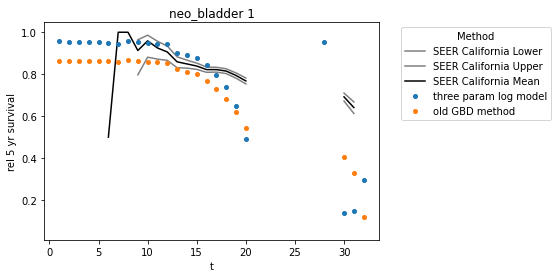

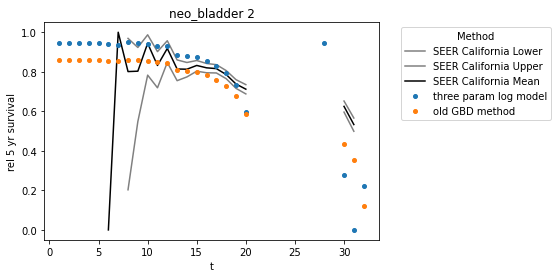

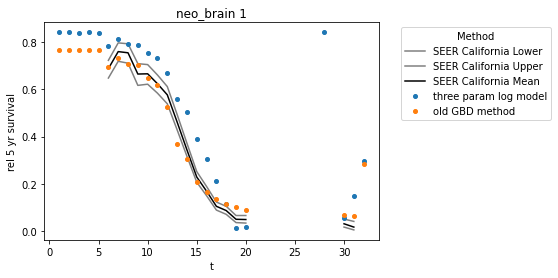

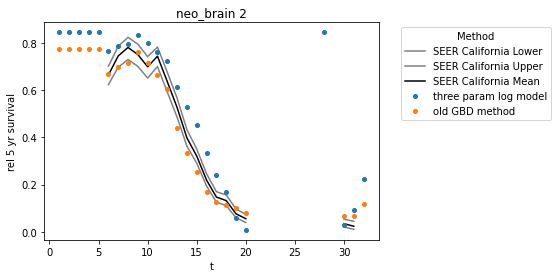

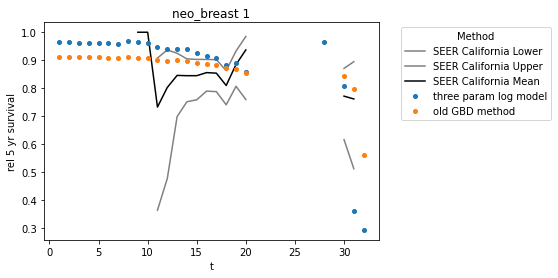

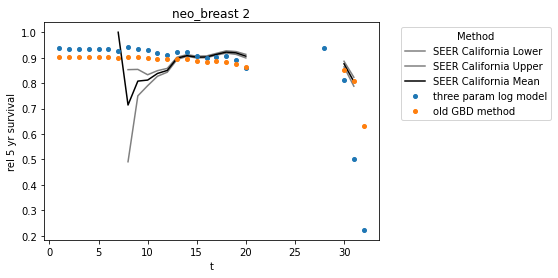

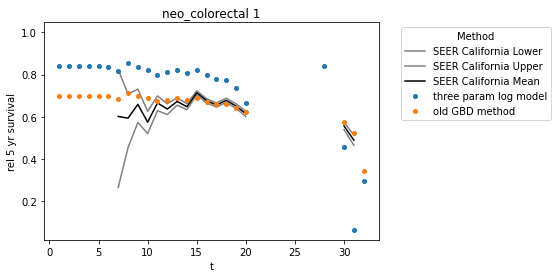

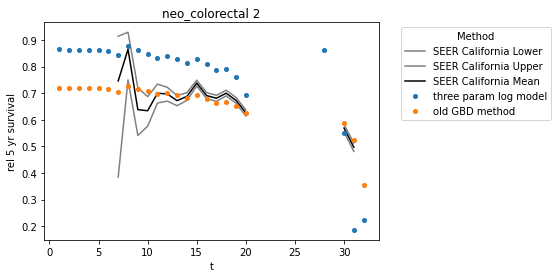

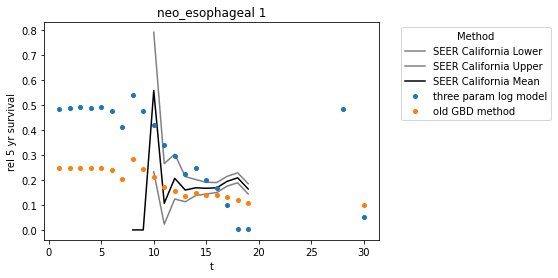

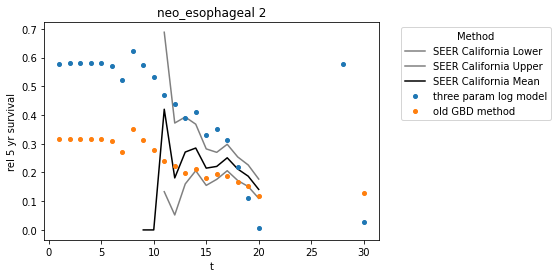

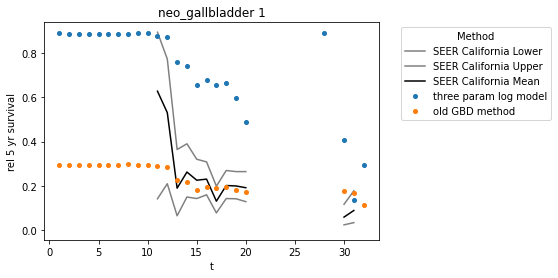

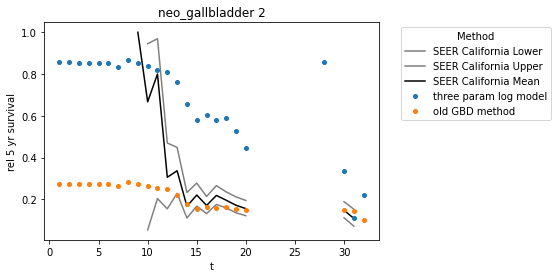

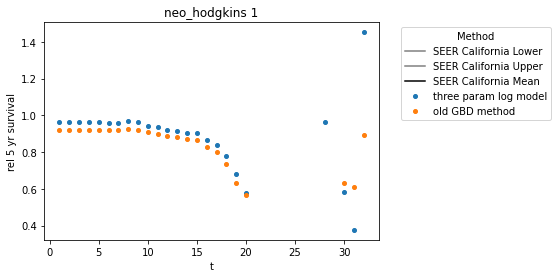

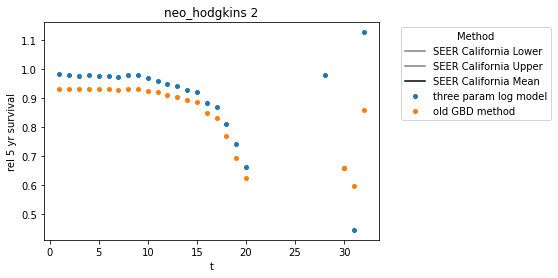

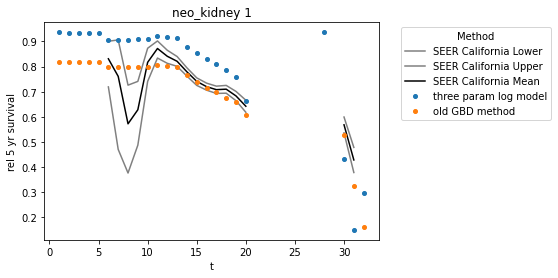

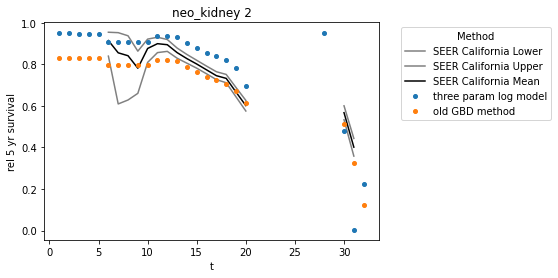

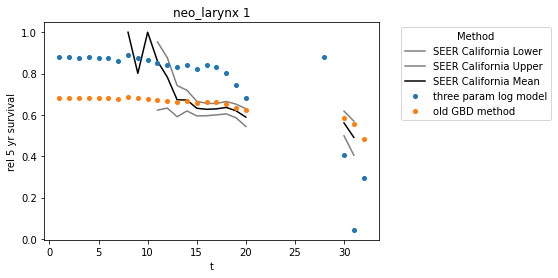

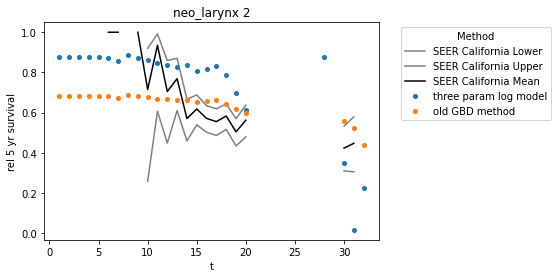

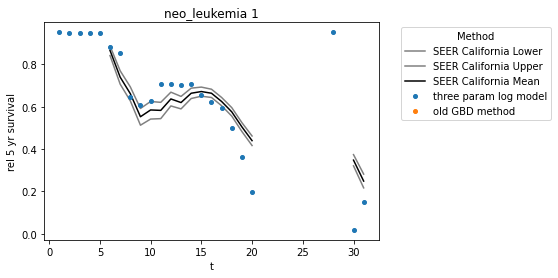

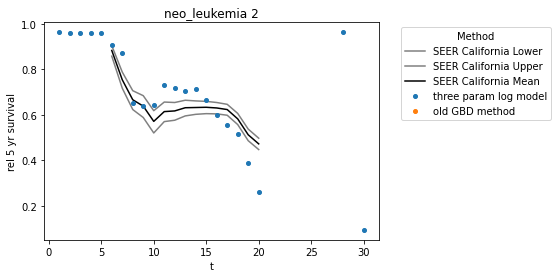

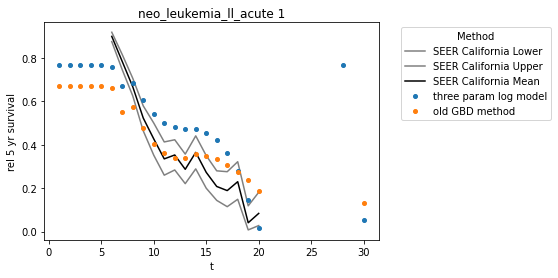

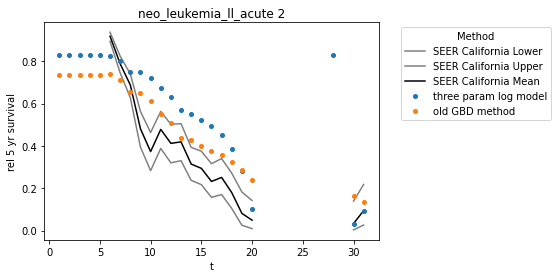

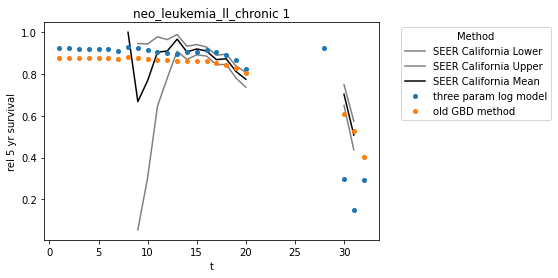

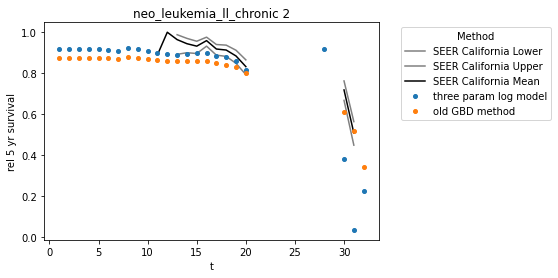

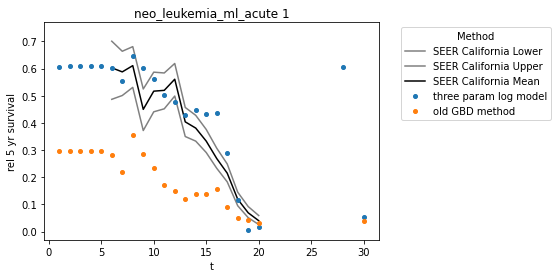

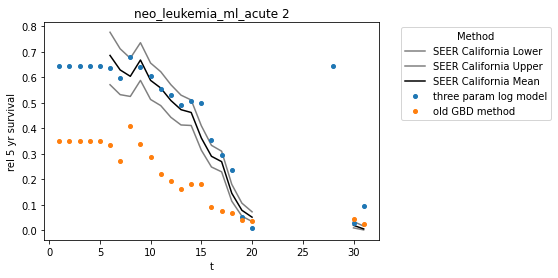

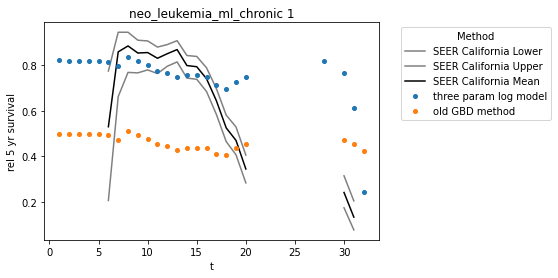

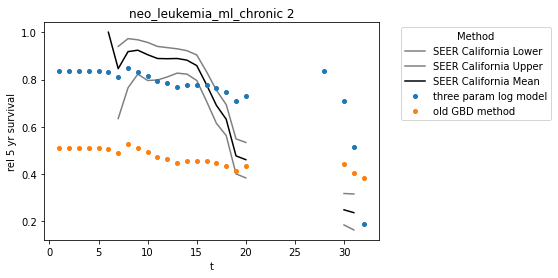

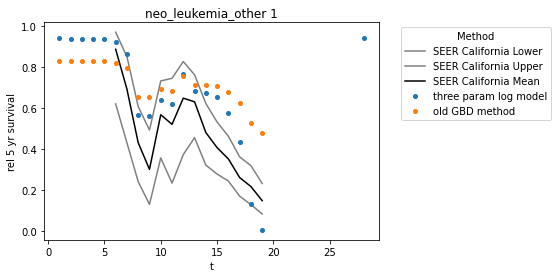

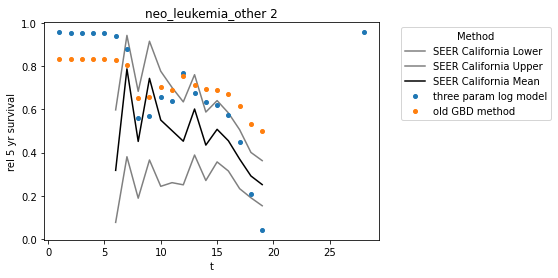

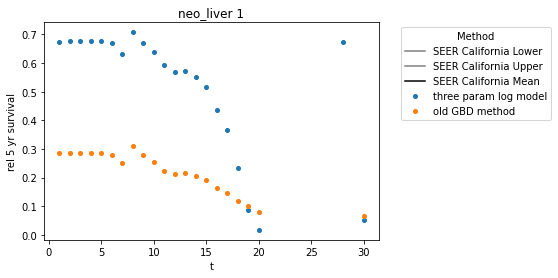

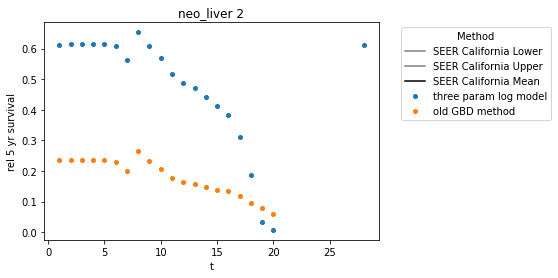

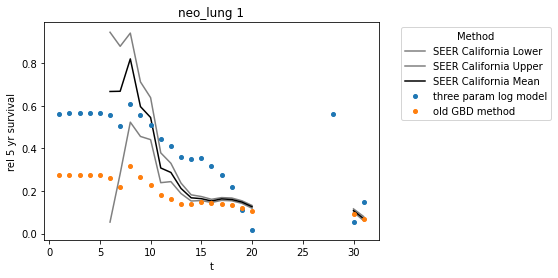

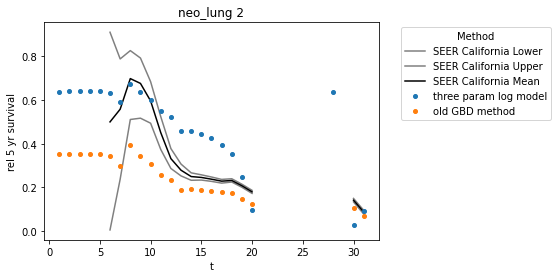

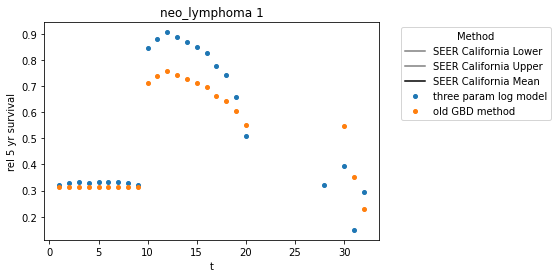

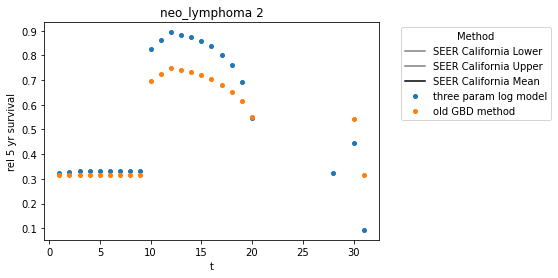

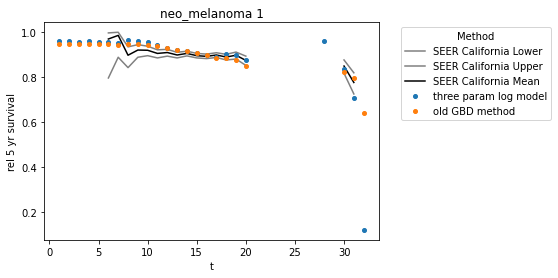

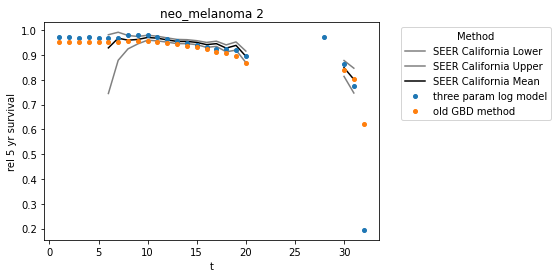

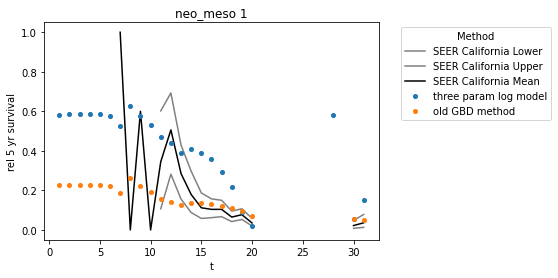

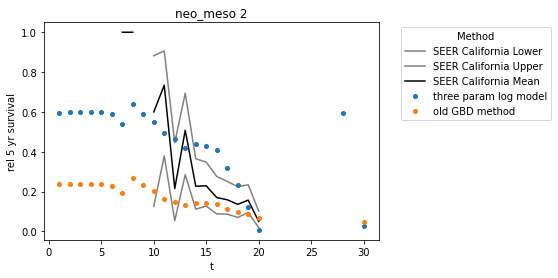

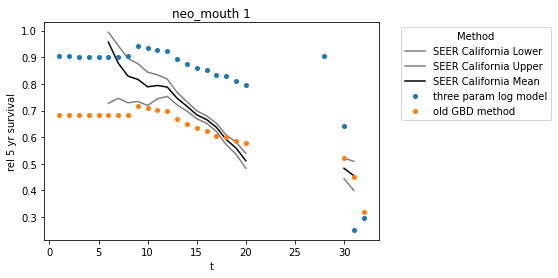

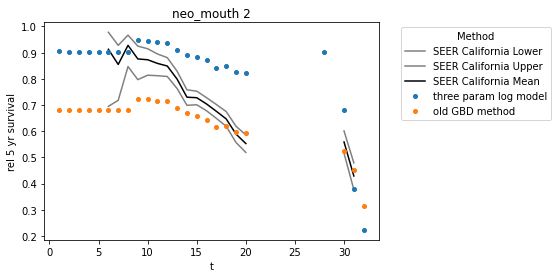

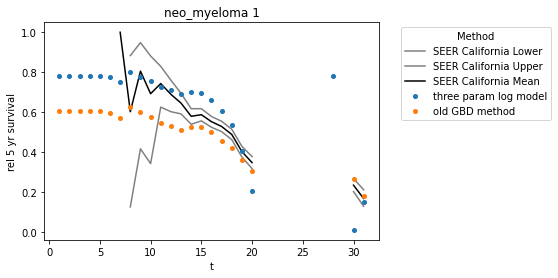

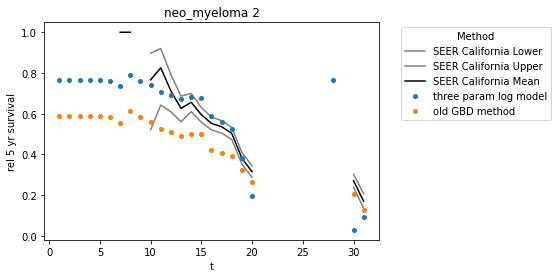

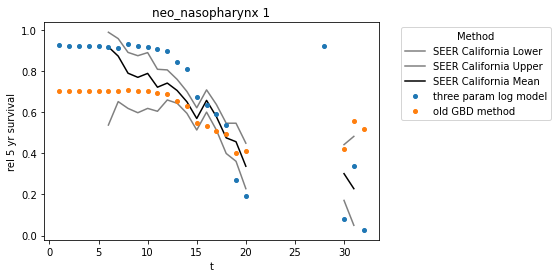

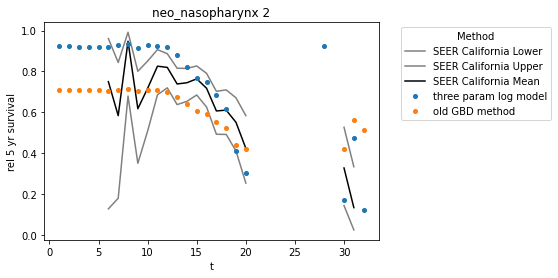

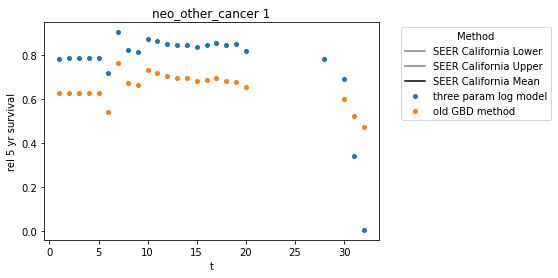

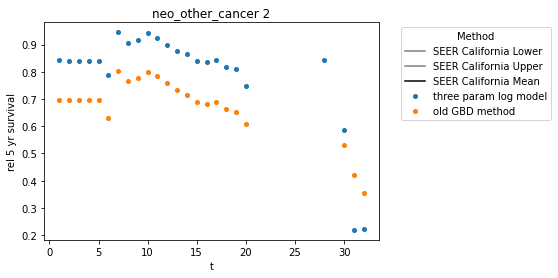

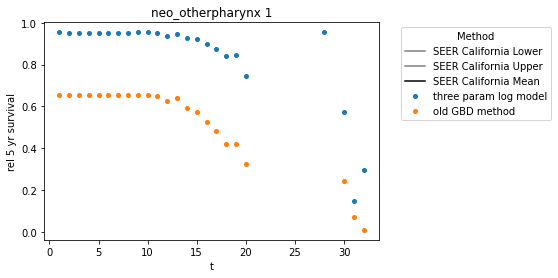

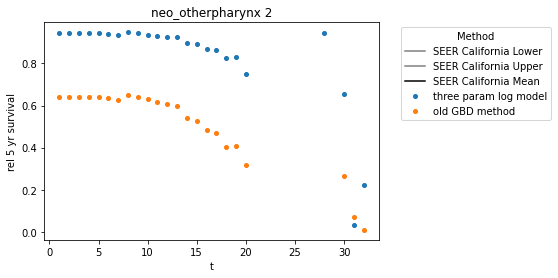

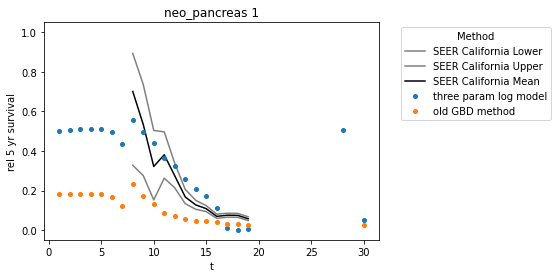

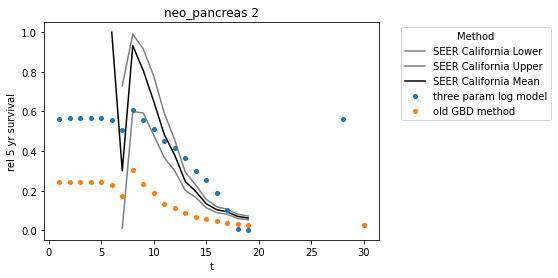

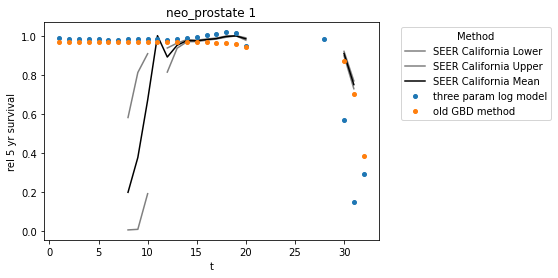

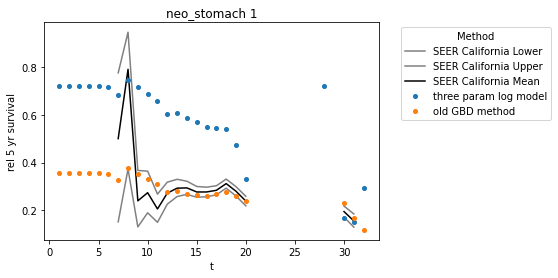

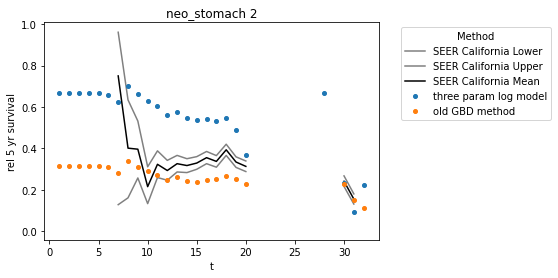

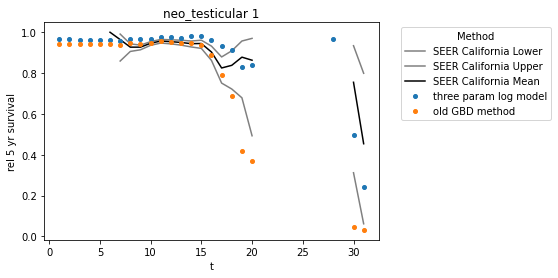

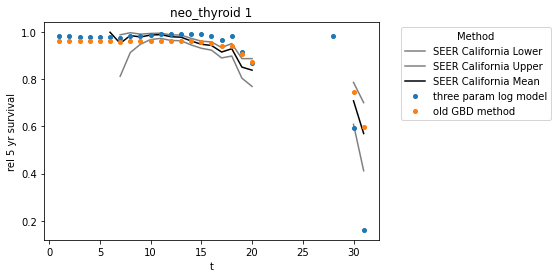

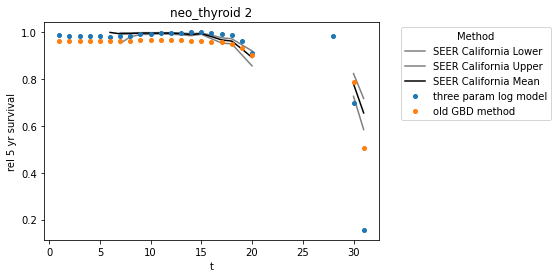

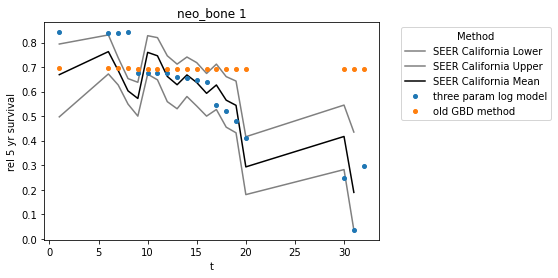

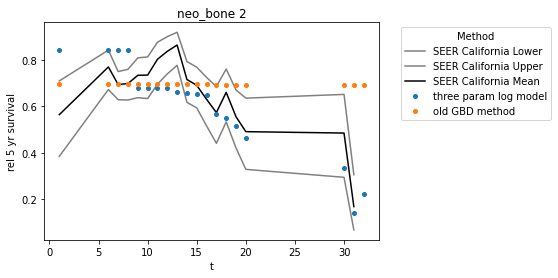

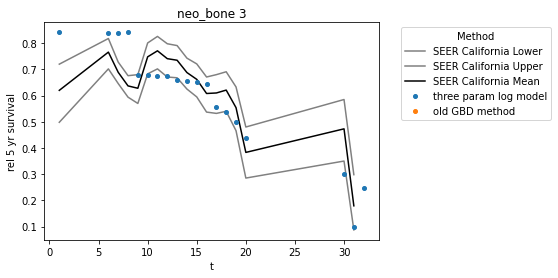

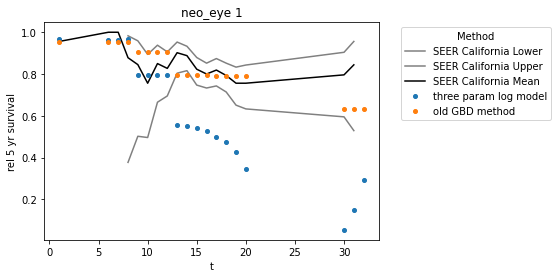

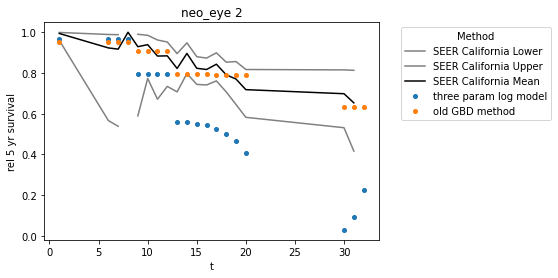

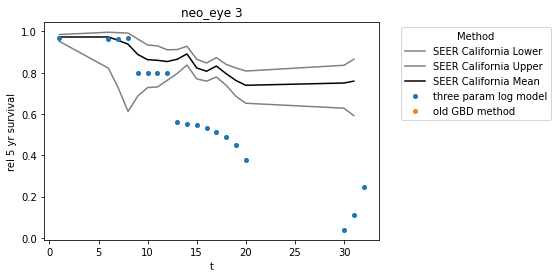

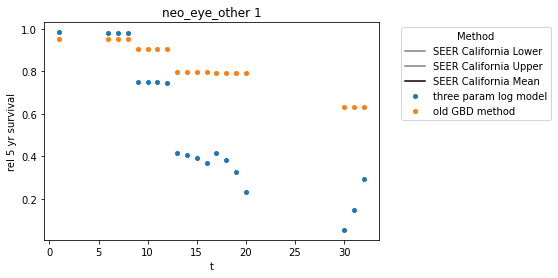

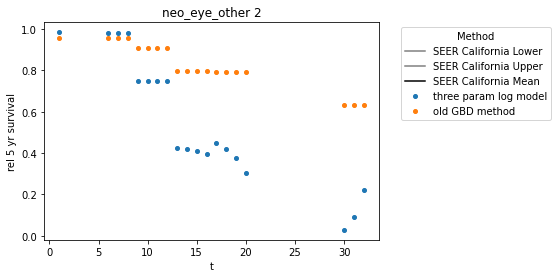

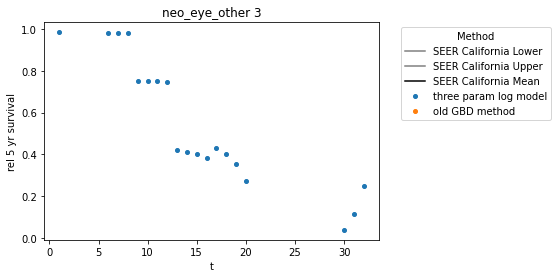

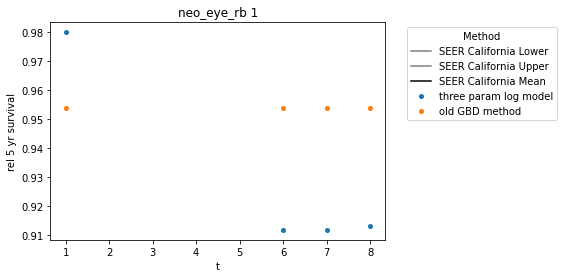

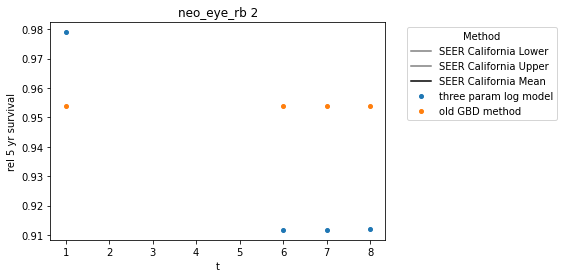

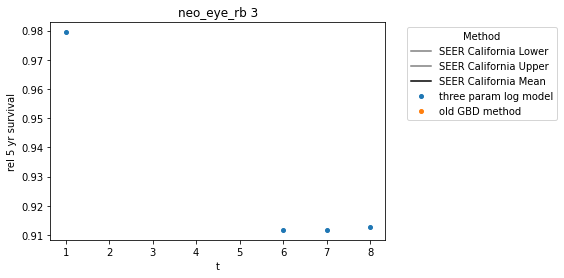

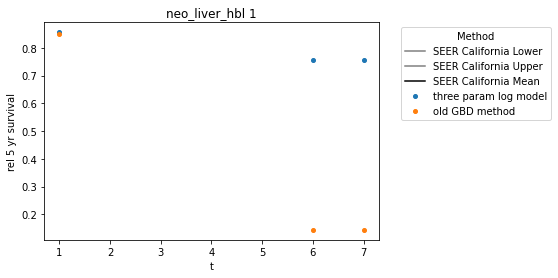

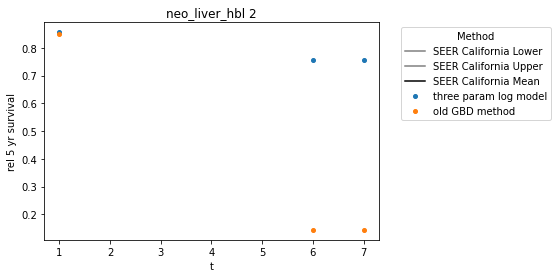

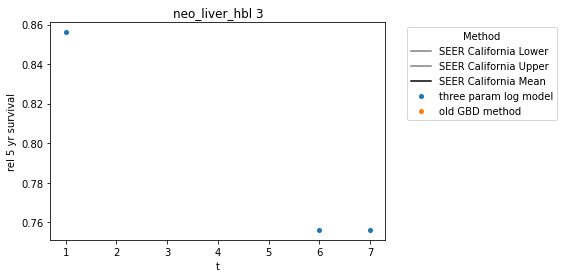

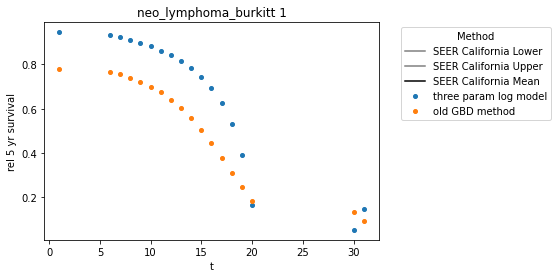

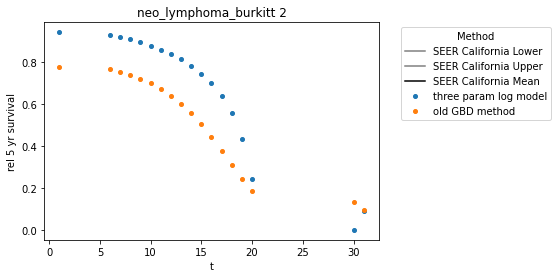

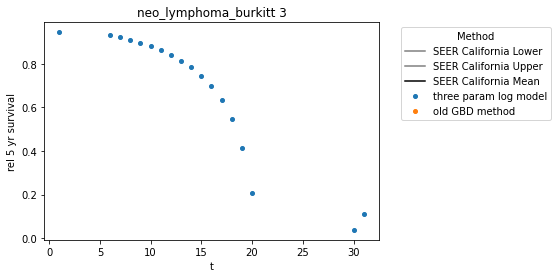

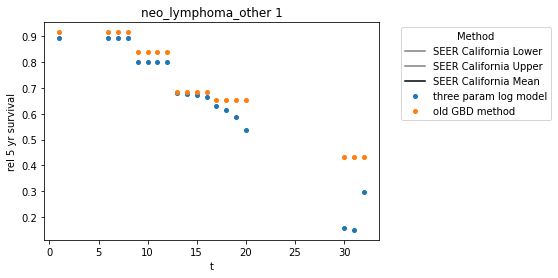

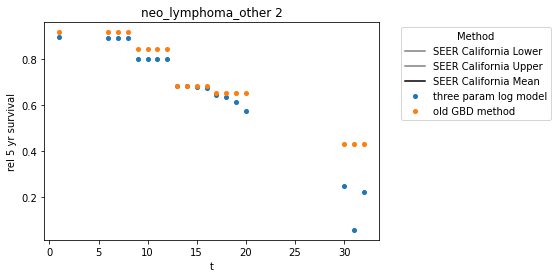

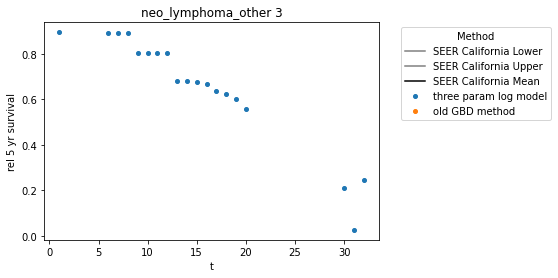

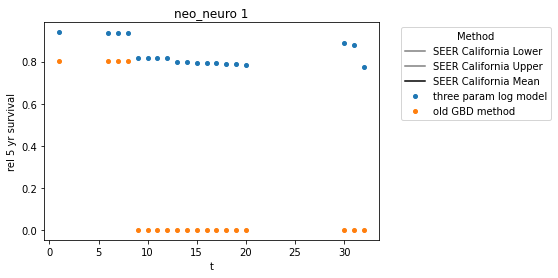

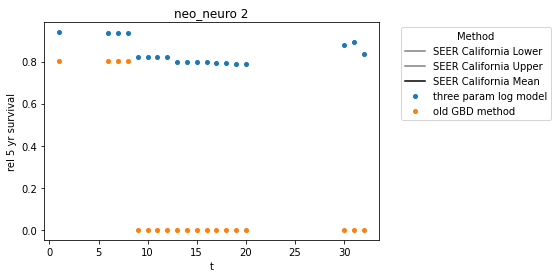

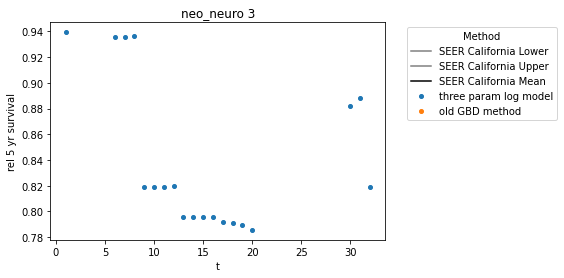

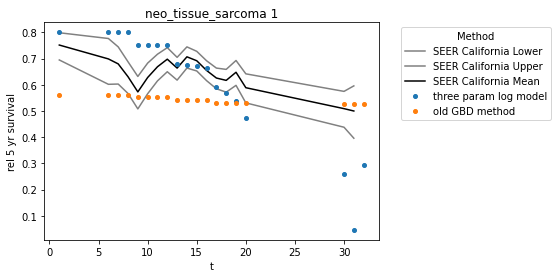

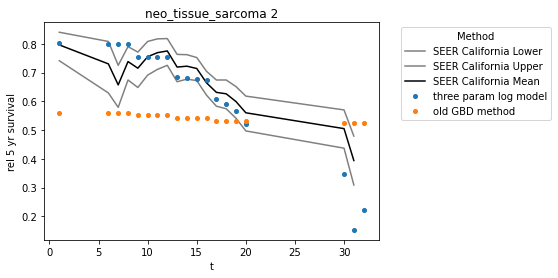

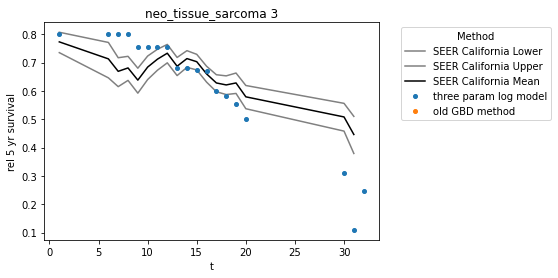

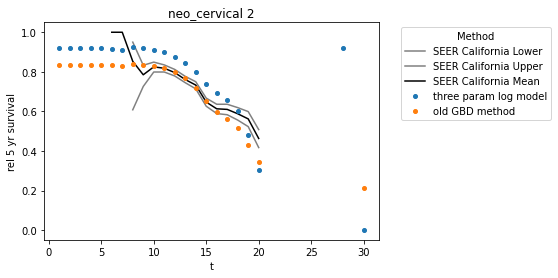

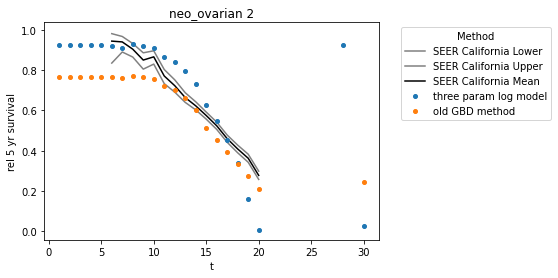

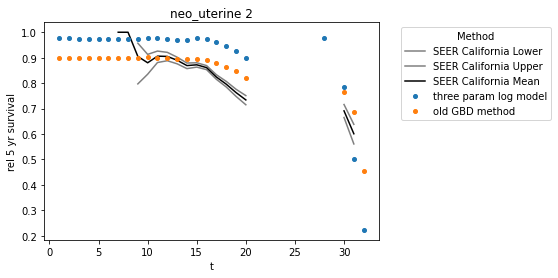

In [7]:
for cancer in df.acause.unique():
        
        cancer_data = df[df['acause']==cancer]
        cancer_data = cancer_data[cancer_data['year_id']==2010]
        
        for sex in cancer_data.sex_id.unique():

            data = cancer_data[cancer_data['sex_id']==sex]
            
            #if(sex==1) sex_name = "Males"
            #else sex_name = "Females"
            
            # PLOT
            #t = seer true abs survival value
            t = data['age_group_id']
            plt.plot(t, data['Rel_Lower'], '-', color='0.5', markersize=5, label='SEER California Lower')
            plt.plot(t, data['Rel_Upper'], '-', color='0.5', markersize=5, label='SEER California Upper')
            plt.plot(t, data['Relative'], '-', color='0',markersize=5, label='SEER California Mean')
            #plt.plot(t, data['rel_survival_rate_og_mir_model'], 'o', markersize=4, label='base model')
            #plt.plot(t, data['rel_survival_rate_age_ext_model'], 'o', markersize=4, label='age extension model')
            #plt.plot(t, data['rel_survival_rate_decay_model'], 'o', markersize=4, label='decay model')
            plt.plot(t, data['rel_survival_rate_three_param_model'], 'o', markersize=4, label='three param log model')
            plt.plot(t, data['rel_survival_old_gbd_model'], 'o', markersize=4, label='old GBD method')
            plt.xlabel("t")
            plt.ylabel("rel 5 yr survival")
            plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.title(cancer+" "+str(sex))
            plt.show()


In [ ]:
df.to_csv('/home/j/temp/fed1/comparing_all_survival_methods_in_CA_6_7_2021.csv')